In [56]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch

import sys
sys.path.insert(1,'../data_utils/')
from Sample import Sample 
from HiCDataset import HiCDataset
from EmbeddedRegions import EmbeddedRegions
from OrigamiTransform import OrigamiTransform
from Sample import Sample
sys.path.insert(2,'../diffusion_origami/')

In [2]:
# Training data locations
config_fp = '../../data/processed_data.hdf5'
embedding_dir = '../../data/embeddings/'

# Supporting data locations 
mean_dist_fp = '../../data/mean_dists.pt'
mean_sq_dist_fp='../../data/squares.pt'

In [16]:
from classifier_free_guidance_greg import Unet, GaussianDiffusion

#### 
model_folder = '../../data/models/diffusion_small_origami'#'./results_small'
training_chroms = ['1'] #f'{k}' for k in range(1,23)]
segment_length = 64
c,image_size = 2,segment_length//2
###

'''
er = EmbeddedRegions(
    embedding_dir,
    chroms=training_chroms
)
'''
embeddings = pd.read_pickle(f'{embedding_dir}/chrom_{training_chroms[0]}.tar.gz')

model = Unet(
    dim=64,
    cond_drop_prob = 0.5,
    init_dim = None,
    out_dim = None,
    dim_mults=(1, 2, 4, 8),
    channels = c,
    resnet_block_groups = 8,
    learned_variance = False,
    learned_sinusoidal_cond = False,
    random_fourier_features = False,
    learned_sinusoidal_dim = 16,
    attn_dim_head = 32,
    attn_heads = 4,
    embedding_dimensions=tuple(er.ifetch(0)[0].shape)
)


diffusion = GaussianDiffusion(
    model,
    image_size=image_size,
    timesteps = 1000,
    sampling_timesteps = None,
    objective = 'pred_noise',
    beta_schedule = 'cosine',
    ddim_sampling_eta = 1.,
    offset_noise_strength = 0.,
    min_snr_loss_weight = False,
    min_snr_gamma = 5
)


#### Support functions. Should be generic to any model in this script

In [53]:
def load_most_recent_milestone(diffusion,folder):

    if folder != '' and folder[-1] != '/': 
        folder = folder + '/'

    files = os.listdir(folder)
    milestone = 0 
    file = ''
    for f in files: 
        m = int('.'.join(f.split('.')[:-1]).split('-')[-1])
        if m > milestone: 
            milestone = m
            file = f
    
    diffusion.load(folder + file)

    return milestone

In [9]:
origami_transform = OrigamiTransform()

In [82]:
def is_square(mat):
    s = mat.shape
    assert len(s) > 1, f'Tensor must have at least two dimensions. Provided shape: {s}'
    return s[-1] == s[-2]

def copy_matrix_elements(from_mat,to_mat):
    assert is_square(from_mat) and is_square(to_mat), f'Both matrices must be square in the final two dimensions'

    n1,n2= from_mat.shape[-1],to_mat.shape[-1]
    n,N = min(n1,n2),max(n1,n2)

    i,j = torch.triu_indices(n,n,0)

    shift1,shift2 = max(0,n1-n2),max(0,n2-n1)
    to_mat[...,i,shift2+j] = from_mat[...,i,shift1+j]
    to_mat[...,shift2+j,i] = from_mat[...,shift1+j,i]
    

def add_diagonal(mat,diag_value=0):
    assert is_square(mat), f'Tensor must be square in the final two dimensions. Provided shape: {s}'
    
    N = mat.shape[-1] + 1
    new_mat = torch.empty(
        *mat.shape[:-2],N,N,
        dtype=mat.dtype,
        device=mat.device
    )
    
    copy_matrix_elements(mat,new_mat)
    i = torch.arange(N)
    new_mat[...,i,i] = diag_value

    return new_mat

def remove_diagonal(mat):
    assert is_square(mat), f'Tensor must be square in the final two dimensions. Provided shape: {s}'

    N = mat.shape[-1] - 1
    new_mat = torch.empty(
        *mat.shape[:-2],N,N,
        dtype=mat.dtype,
        device=mat.device
    )
    
    copy_matrix_elements(mat,new_mat)
    
    return new_mat

class Sampler: 

    def __init__(
        self,
        diffusion=diffusion,
        embeddings=embeddings,
        cond_scale=5,
        rescaled_phi=0.5,
        nsamples=100
    ):

        self.diffusion = diffusion
        self.embeddings = embeddings
        self.cond_scale = cond_scale
        self.rescaled_phi = rescaled_phi
        self.nsamples = nsamples

    def __call__(
        self,
        region_index=None,
        *,
        embedding=None,
        nsamples = None,
        diffusion=None,
        embeddings=None,
        cond_scale=None,
        rescaled_phi=None,
        return_raw = False,
    ):
        assert (region_index is None) ^ (embedding is None), "Must pass EITHER region_index OR embedding"

        # Set the necessary options
        nsamples = self.nsamples if nsamples is None else nsamples
        diffusion = self.diffusion if diffusion is None else diffusion
        embeddings = self.embeddings if embeddings is None else embeddings
        cond_scale = self.cond_scale if cond_scale is None else cond_scale
        rescaled_phi = self.rescaled_phi if rescaled_phi is None else rescaled_phi

        # Get the desired embedding and expand it to the desired sample size
        emb = embedding if region_index is None else embeddings.iloc[region_index,0]
        emb = emb.to(diffusion.device).expand(nsamples,-1,-1,-1)

        # Sample with the diffusion model
        data = diffusion.sample(emb,cond_scale=cond_scale,rescaled_phi=rescaled_phi)

        if return_raw: 
            return data 
            
        # Reverse the origami transform
        data = origami_transform.inverse(data)

        # Remove the diagonal so that we can directly use the Sample class
        data = remove_diagonal(data) 

        # Make a Sample object
        sample = Sample(data=data)

        return sample

    def get_valid_attributes(self):
        valid_attributes = []
        for attr in dir(self): 
            if attr[0] != '_' and not callable(getattr(self, attr)): 
                valid_attributes.append(attr)
        return valid_attributes
    
    def set(self,**kwargs):
        '''
        Options: 
        diffusion
        embedded_regions
        cond_scale
        rescaled_phi
        nsamples
        '''
        assert len(kwargs) > 0, f'Expected at least one keyword argument.'
        attrs = self.get_valid_attributes()
        for attr,value in kwargs.items():
            assert attr in attrs, f'Error: Keyword argument {attr} not recognized. Valid attributes to set are: {attrs}.'
            assert type(value) == type(getattr(self,attr)), f'Expected type {type(getattr(self,attr))} for attribute {attr}, but received {type(value)}.'
        for attr, value in kwargs.items():
            setattr(self, attr, value)
            

In [83]:
import torch

def distance_hist(exp_data,gen_data,*args):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.hist(exp_data.flatten().cpu().numpy(),alpha=0.5,label='Experimental')
    ax.hist(gen_data.flatten().cpu().numpy(),alpha=0.5,label='Generated')
    ax.legend()

    return fig,ax

def is_int(x):
    return int(x) == x

class DistanceCompare: 

    def __init__(self,config_dataset,sample=None,indices=None,device=None):

        self.exp_ds = config_dataset
        self.gen_configs = sample
        self.idx = indices
        self.device = device

        self.exp_maps = None

    ###################################################################
    # Handling the experimental data
    def parse_index(self,region_index): 
        assert is_int(region_index), 'region_index must be an integer'
        _,chrom,start_idx = self.idx[region_index]
        return chrom,start_idx
    
    def get_coords(self,*args):
        assert len(args) > 0, 'Expected either integer input (region index) or string (chrom) followed by integer (starting index). Received no arguments.'
        assert len(args) < 3, f'Expected either integer input (region index) or string (chrom) followed by integer (starting index). Received {len(args)} arguments.'
        if len(args) == 1: 
            assert type(args[0]) == int, f'Expected either integer input (region index) or string (chrom) followed by integer (starting index). Received one {type(args[0])} input.'
            chrom,start_idx = self.parse_index(int(args[0]))
        elif type(args[0]) != str or not is_int(args[1]): 
            raise Exception('Expected either integer input (region index) or string (chrom) followed by integer (starting index). '+\
                            f'Received types {type(args[0])} and {type(args[1])}.')
        else:
            chrom,start_idx = args[0],int(args[1])
        return self.exp_ds.fetch_specific_coords(chrom,start_idx)[1].to(self.device)
    
    def get_exp_maps(self,*args):
        if len(args) == 0:
            return self.exp_maps
        coords = self.get_coords(*args) 
        dists = torch.cdist(coords.double(),coords.double()).float()
        return dists

    def set_exp_maps(self,*args):
        self.exp_maps = self.get_exp_maps(*args)

    ###################################################################
    # Handling the generated data 
    def set_sample(self,sample):
        self.gen_configs = sample.clone()
        self.gen_configs.unnormalize_()

    def load_sample(self,fp):
        sample = Sample(data=pd.read_pickle(fp).batch)
        self.set_sample(sample) 
        
        
    ###################################################################
    # Comparisons
    def dist_compare(self,pairs=None):
        gen_data = self.gen_configs.unflatten()
        exp_data = self.get_exp_maps()
        n, N = gen_data.shape[-1], exp_data.shape[-1]

        if n == N-1: 
            gen_data = add_diagonal(gen_data) 
        else: 
            assert n==N, 'incompatible generated/experimental data sizes'

        if pairs is None: 
            pairs = torch.triu_indices(N,N,1).T.tolist()

        results = {}
        for pair in pairs: 
            i,j = pair[0],pair[1]
            results[pair] = [exp_data[...,i,j].flatten(),gen_data[...,i,j].flatten()]

        return results 
    

In [55]:
del Sample

#### Should be generic to any model 

In [59]:
milestone = load_most_recent_milestone(diffusion,model_folder) 
sampler = Sampler(diffusion=diffusion)

In [81]:
sample = sampler(200,nsamples=100,cond_scale=3.,rescaled_phi=.3)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

In [84]:
#import pickle
#pickle.dump(sample,open('origami_sample1.pkl','wb'))

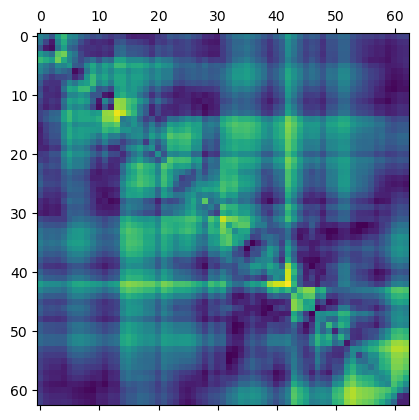

In [85]:
plt.matshow(sample.unflatten()[0,0,...].cpu().numpy())

(<Figure size 640x480 with 2 Axes>,
 <Axes: >,
 <matplotlib.colorbar.Colorbar at 0x7f6020415fc0>)

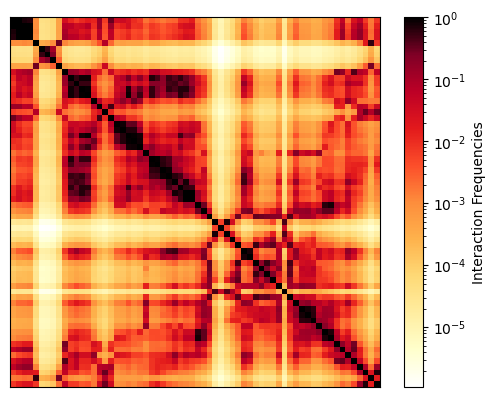

In [87]:
sample._unnormalize_()
sample.unflatten_()
hic_map = sample.contact_probabilities(r_c=1.75,sigma=3.5)
hic_map.plot()